In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import madmom
import mir_eval
from modules.analysis_funcs import aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

madmom.features.onsets.CNNOnsetProcessor()

In [157]:
from datasets import Dataset
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
audio_lengths = [len(audio)/sr for audio, sr in zip(audios, sample_rates)]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [188]:
bock = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.PeakPickingProcessor(threshold=0.7)
TOL = 0.025
THRESS = [0.3,0.4,0.5,0.6,0.7]
cds = np.zeros((len(THRESS), len(audio_fnames)))
fps = np.zeros((len(THRESS), len(audio_fnames)))
fns = np.zeros((len(THRESS), len(audio_fnames)))

In [24]:
for t, THRES in enumerate(THRESS):
    for a, (fname, audio, onsets, sr) in enumerate(zip(audio_fnames, audios, onset_schedules, sample_rates)):
        bock = madmom.features.onsets.CNNOnsetProcessor()
        pp = madmom.features.onsets.PeakPickingProcessor(threshold=THRES)
        act_fn = bock(audio)
        peaks = pp(act_fn)
        [CD,FN,FP,doubles,merged] = evaluate(onsets, peaks, tol_sec=TOL)
        cds[t, a] = CD
        fps[t, a] = FP
        fns[t, a] = FN
        print(fname)

/usr/local/lib/python3.9/site-packages/madmom/features/onsets.py:996: UserWarning: `PeakPickingProcessor` is deprecated as of version 0.15 and will be removed in version 0.16. Use `OnsetPeakPickingProcessor` instead.
  warnings.warn('`PeakPickingProcessor` is deprecated as of version '


datasets/initslurtest_vn/initslurtest_vn_wav/slurtest01.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest02.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest03.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest04.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest05.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest06.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest07.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest08.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest09.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest10.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest11.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest12.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest13.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest14.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest15.wav
datasets/initslurtest_vn/initslurtest_vn_wav/slurtest16.wav
datasets/initslurtest_vn/initslurtest_vn

In [25]:
np.save(file="results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_fns.npy", arr=fns)
np.save(file="results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_fps.npy", arr=fps)
np.save(file="results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_cds.npy", arr=cds)

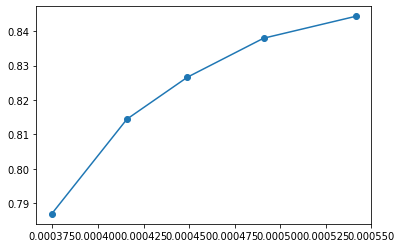

In [29]:
cds = np.load("results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_cds.npy")
fns = np.load("results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_fns.npy")
fps = np.load("results/madmomCNNOnsetProcessor/bock_raw_AB_tuning_fps.npy")
tns = 133064 - cds - fns - fps
tpr = cds.sum(1)/(cds.sum(1)+fns.sum(1))
fpr = fps.sum(1)/(fps.sum(1)+tns.sum(1))
fscores = cds.sum(1)/(cds.sum(1)+0.5*fps.sum(1)+0.5*fns.sum(1))
rec = cds.sum(1)/(cds.sum(1)+fns.sum(1))
prec = cds.sum(1)/(cds.sum(1)+fps.sum(1))
f_half = 1.25*prec*rec/(0.25*prec+rec)
plt.plot(fpr, tpr, '-o')
plt.show()


In [30]:
print(fscores)
print(rec)
print(prec)
print(f_half)

[0.65019564 0.66497696 0.67456463 0.68082524 0.68201837]
[0.84436702 0.83797909 0.82665505 0.81445993 0.78687573]
[0.52863116 0.55118411 0.56974185 0.58486239 0.60182101]
[0.57136121 0.59168443 0.60750256 0.61980732 0.63152498]


In [201]:
def onset_visualizer(audio, onset_list, lims, ax=None, **plt_kwargs):
    ONSET_MARKERS = ["v", "^", "^"]
    ONSET_COLORS = ["k", "r", "g"]
    if ax is None:
        ax = plt.gca()
    o = 0
    ax.plot(np.linspace(lims[0], lims[1], len(audio)), audio, zorder=0, **plt_kwargs)

    while o<len(onset_list):
        if o<len(ONSET_MARKERS) and o<len(ONSET_COLORS):
            ax.scatter(onset_list[o], np.zeros_like(onset_list[o]), 
                    marker=ONSET_MARKERS[o], c=ONSET_COLORS[o], zorder=len(onset_list)+10-o
            )
        else:
            ax.scatter(onset_list[o], np.zeros_like(onset_list[o])),
        o+=1
    return ax

In [202]:
def passage_extractor(audio, onset_list, breakpoints, sr=44100):
    return [{
            "audio" : audio[int(start*sr):int(end*sr)],
            "onsets": [onsets[np.intersect1d(
                np.where(onsets-start>0),
                np.where(onsets-end<0)
            )] for onsets in onset_list],
            "abs_start" : start,
            "abs_end" : end
        } for start, end in zip(breakpoints[:-1], breakpoints[1:])]


In [203]:
def merging_module(note_onsets, hard_onsets, tol_sec):
    out_onsets = []
    for t in range(len(note_onsets)):
        matches = np.where(np.abs(hard_onsets-note_onsets[t])<tol_sec, 1, 0)
        if np.sum(matches)>0:
            out_onsets.append(note_onsets[t])
    return np.array(out_onsets)
    

Audio length:  29.141043083900225  s
Segments: [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0]


/usr/local/lib/python3.9/site-packages/madmom/features/onsets.py:996: UserWarning: `PeakPickingProcessor` is deprecated as of version 0.15 and will be removed in version 0.16. Use `OnsetPeakPickingProcessor` instead.
  warnings.warn('`PeakPickingProcessor` is deprecated as of version '


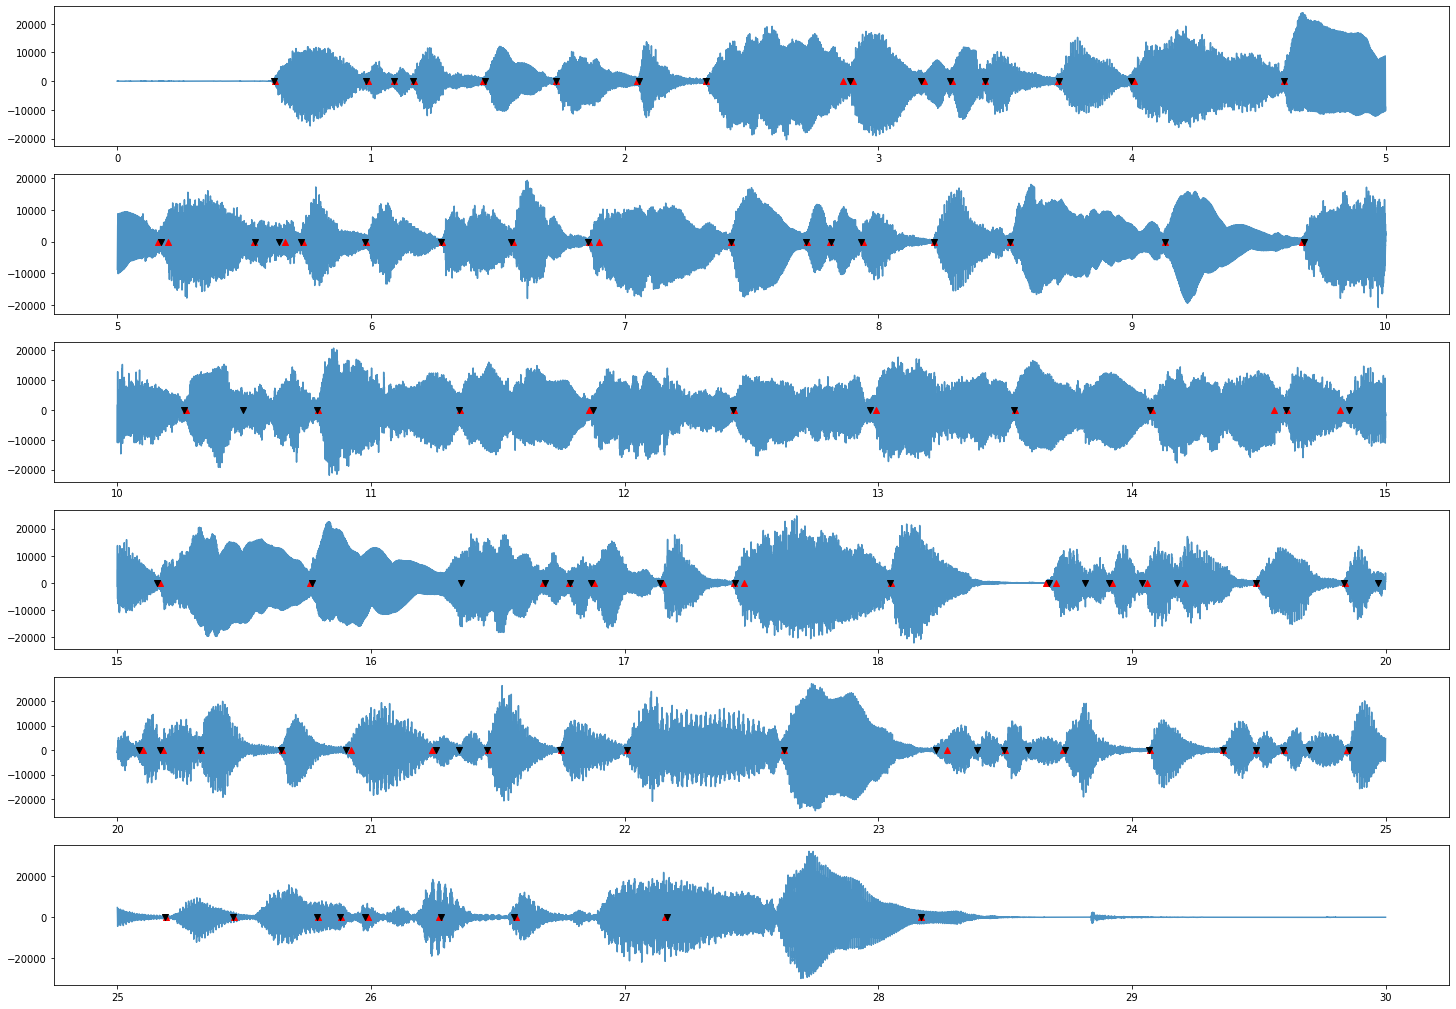

In [210]:

REC_NO = 8
R = REC_NO-1
SPP = 5.0 # seconds per plot
print("Audio length: ", audio_lengths[R], " s")
print("Segments:", list(np.arange(0, audio_lengths[R]+SPP, SPP)))
N_PLOTS = int(audio_lengths[R]/SPP)+1

qual_onsets = merging_module(pp(bock(audios[R])), onset_schedules[R], tol_sec=0.05)
fig, axs = plt.subplots(N_PLOTS, 1, figsize=(25,N_PLOTS*3))
passages = passage_extractor(
    audios[R], 
    [
        onset_schedules[R],
        qual_onsets
    ], 
    list(np.arange(0, audio_lengths[R]+SPP, SPP)), 
    sr=sample_rates[R]
)
for passage, ax in zip(passages, axs):
    onset_visualizer(passage["audio"], passage["onsets"], lims=(passage["abs_start"], passage["abs_end"]), ax=ax, alpha=0.8)

In [127]:
onset_schedules[0]

array([ 0.767   ,  1.447   ,  2.056   ,  2.202   ,  2.341793,  2.469   ,
        2.637   ,  2.809448,  2.917   ,  3.047   ,  3.247   ,  3.848   ,
        4.457   ,  4.609   ,  4.746   ,  4.888   ,  5.04    ,  5.177   ,
        5.319   ,  5.451877,  5.667   ,  6.297   ,  6.896   ,  7.053509,
        7.177   ,  7.317   ,  7.486   ,  7.608   ,  7.758   ,  7.871   ,
        8.078   ,  8.656899,  8.823039,  9.258   ,  9.398   ,  9.529   ,
        9.687   ,  9.854   ,  9.987   , 10.147   , 10.272   , 10.486   ,
       11.118243, 11.627   , 11.777   , 11.929607, 12.068   , 12.248   ,
       12.37177 , 12.518   , 12.647   , 12.866   , 13.437   , 14.007   ,
       14.138   , 14.287   , 14.415   , 14.577   , 14.717079, 14.848   ,
       14.974   , 15.158   ])

In [184]:
audio_fnames[7]

'datasets/initslurtest_vn/initslurtest_vn_wav/slurtest08.wav'